BRAIN TUMOR SEGMENTATION USING U NET

Using deep learning model for automatic brain tumor segmentation using the U-Net architecture. The goal was to accurately identify and segment tumor regions from MRI images.

I used convolutional neural networks to extract spatial features and applied an encoder–decoder structure with skip connections to preserve fine details.

The model was trained on medical imaging data and evaluated using segmentation metrics such as Dice coefficient and IoU.

This system helps improve diagnostic accuracy and supports doctors in treatment planning by providing precise tumor boundaries.”*

In [ ]:
#File & System Handling
import os
import glob
import random
import shutil
#Image Processing
import cv2
import PIL
from PIL import Image
import skimage.transform
#Medical Data
import nibabel as nib
#Data Handling
import numpy as np
import pandas as pd
#Visualization
import matplotlib
import matplotlib.pyplot as plt
#Deep Learning
import tensorflow as tf
import keras
from tensorflow.keras.layers import *
import keras.backend as K
from keras.callbacks import CSVLogger
#Image Processing (scikit-image)
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
#Data Scaling & Splitting (scikit-learn)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#Model Visualization
from tensorflow.keras.utils import plot_model
#Model Building (Keras Layers)
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
#Optimization
from tensorflow.keras.optimizers import *
#Training Control (Callbacks)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# IMPORTANT FIX FOR TF 2.14+
from tensorflow.keras import layers



“This function automatically locates all MRI modalities and segmentation masks from a patient folder using keyword matching. It makes the preprocessing pipeline flexible and dataset-independent.”

In [ ]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
import cv2

def find_modalities(case_path):
    """
    case_path: folder like .../BraTS20_Training_355
    returns full paths for (t1, t1ce, t2, flair, seg)
    """
    #Read Files
    files = os.listdir(case_path)
    files_lower = [f.lower() for f in files]
    #Inner Function: pick()
    def pick(mod_keyword, extra_cond=None):
        for f, fl in zip(files, files_lower):
            if mod_keyword in fl:
                if extra_cond is None or extra_cond(fl):
                    return os.path.join(case_path, f)
        raise FileNotFoundError(f"Cannot find file with keyword '{mod_keyword}' in {case_path}")

    # be careful that t1 is not t1ce
    t1_path    = pick("t1.",   extra_cond=lambda fl: "t1ce" not in fl)
    t1ce_path  = pick("t1ce")
    t2_path    = pick("t2.")
    flair_path = pick("flair")
    seg_path   = pick("segm")   # matches 'W39_1998.09.19_Segm.nii'
    #Final Return
    return t1_path, t1ce_path, t2_path, flair_path, seg_path


Dataset Information
The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:

Native (T1)
Post-contrast T1-weighted (T1ce - contrast enhanced)
T2-weighted (T2)
T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)
These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):

Label 0: Not Tumor (NT) volume
Label 1: Necrotic and non-enhancing tumor core (NCR/NET)
Label 2: Peritumoral edema (ED)
Label 3: Missing (No pixels in all the volumes contain label 3)
Label 4: GD-enhancing tumor (ET)
As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

Connects Google Drive to Google Colab
, Loads MRI dataset paths from Drive
, Lets you train on large files without uploading every time

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
#Define Training Dataset Path
TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
#Define Validation Dataset Path
VAL_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Confirms that the dataset path is correct
 ,Checks whether files are accessible
,Displays sample folders
 ,Prevents silent data-loading errors

In [ ]:

#Print Dataset Path
print(TRAIN_DATASET_PATH)
print(os.listdir(TRAIN_DATASET_PATH)[:5])


/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
['survival_info.csv', 'name_mapping.csv', '.DS_Store', 'BraTS20_Training_209', 'BraTS20_Training_200']


In [ ]:
TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

import os
print(TRAIN_DATASET_PATH)
print(os.listdir(TRAIN_DATASET_PATH)[:5])   # should show 'BraTS20_Training_001', ...


/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
['survival_info.csv', 'name_mapping.csv', '.DS_Store', 'BraTS20_Training_209', 'BraTS20_Training_200']


In [ ]:
TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
VAL_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

How big each image will be, How many MRI slices are used
, Which slices are selected
, Which MRI modalities are used

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from keras.utils import Sequence

# -------- global settings --------
#Image Size
IMG_SIZE = 128
#Number of Slices
VOLUME_SLICES = 100
#Start Slice
VOLUME_START = 22
#Number of Channels
N_CHANNELS = 2        # flair, t1ce


TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"


Selects one MRI patient case
, Builds the full file path
, Checks if the folder exists
, Lists all MRI files inside it

In [ ]:
import os
#Selecting One Case
case = "BraTS20_Training_355"   # <-- choose ONE folder name from the list
#Building the Path
case_path = os.path.join(TRAIN_DATASET_PATH, case)
#Printing Path
print("CASE PATH:", case_path)
print("FILES INSIDE CASE FOLDER:")
#Checking Folder Exists
if not os.path.exists(case_path):
    print("❌ This path does NOT exist.")
else:
  #Listing Files
    for f in os.listdir(case_path):#All MRI modalities,Segmentation mask
        print("  →", f)


CASE PATH: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355
FILES INSIDE CASE FOLDER:
  → BraTS20_Training_355_flair.nii
  → BraTS20_Training_355_t1.nii
  → BraTS20_Training_355_t1ce.nii
  → BraTS20_Training_355_t2.nii
  → W39_1998.09.19_Segm.nii


Builds the full path for case 355, Prints the path
,Lists all files inside that folder

In [ ]:
#Creating Path
CASE355_PATH = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355")
#Printing Path
print(CASE355_PATH)
#Listing Files
print(os.listdir(CASE355_PATH))


/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355
['BraTS20_Training_355_flair.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii', 'BraTS20_Training_355_t2.nii', 'W39_1998.09.19_Segm.nii']


Fixes inconsistent file naming in your dataset
, Renames the segmentation file to match the dataset standard
,Prevents the pipeline from breaking later

In [ ]:
import os

# Old and new names for the seg file of case 355
old_name = TRAIN_DATASET_PATH + "/BraTS20_Training_355/M3_1998.09.19_seg.nii"
new_name = TRAIN_DATASET_PATH + "/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file (or skipping if it's already renamed)
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully.")
except FileNotFoundError:
    print("File is already renamed.")


File is already renamed.


Finds the correct MRI files

Loads them using nibabel

Supports both .nii and .nii.gz formats

Reads multiple modalities

Verifies that all images have the same shape

In [ ]:
import os
import nibabel as nib
import numpy as np

# Function that tries .nii and .nii.gz
def load_any(case_path, case_prefix):
    for ext in [".nii.gz", ".nii"]:
        path = os.path.join(case_path, case_prefix + ext)
        if os.path.exists(path):
            return nib.load(path).get_fdata()
    raise FileNotFoundError(f"Cannot find file for prefix {case_prefix}")

# -------------------------------
# SET THE CASE NAME
# -------------------------------
CASE = "BraTS20_Training_355"
CASE_PATH = os.path.join(TRAIN_DATASET_PATH, CASE)

print("CASE PATH:", CASE_PATH)
print("FILES:", os.listdir(CASE_PATH))

# -------------------------------
# MRI modalities
# -------------------------------
t1_img   = load_any(CASE_PATH, f"{CASE}_t1")
t1ce_img = load_any(CASE_PATH, f"{CASE}_t1ce")
t2_img   = load_any(CASE_PATH, f"{CASE}_t2")
flair_img = load_any(CASE_PATH, f"{CASE}_flair")

# -------------------------------
# Segmentation (special filename!)
# -------------------------------
seg_prefix = "W39_1998.09.19_Segm"
seg_img = load_any(CASE_PATH, seg_prefix)

# -------------------------------
# Print shapes
# -------------------------------
print("Shapes:")
print(" t1:   ", t1_img.shape) #Brain structure
print(" t1ce: ", t1ce_img.shape)#Active tumor regions
print(" t2:   ", t2_img.shape)#Fluid and edema
print(" flair:", flair_img.shape)#Lesions near CSF
print(" seg:  ", seg_img.shape)


CASE PATH: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355
FILES: ['BraTS20_Training_355_flair.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii', 'BraTS20_Training_355_t2.nii', 'W39_1998.09.19_Segm.nii']
Shapes:
 t1:    (240, 240, 155)
 t1ce:  (240, 240, 155)
 t2:    (240, 240, 155)
 flair: (240, 240, 155)
 seg:   (240, 240, 155)


Selects one MRI case
,Finds the FLAIR modality
, Loads it into NumPy
, Checks its shape
, Checks intensity range (min / max)

In [ ]:
import os
import nibabel as nib
import numpy as np

# one example case – we can change this
CASE = "BraTS20_Training_355"
#Build Path
CASE_PATH = os.path.join(TRAIN_DATASET_PATH, CASE)
print("CASE_PATH:", CASE_PATH)
#List Files
print("FILES:", os.listdir(CASE_PATH))

# find the flair file in that folder
flair_file = [f for f in os.listdir(CASE_PATH) if "_flair" in f][0]
#Build File Path
flair_path = os.path.join(CASE_PATH, flair_file)
print("FLAIR FILE:", flair_path)

# load  MRI volume as numpy array
test_image_flair = nib.load(flair_path).get_fdata().astype(np.float32)
#Check Shape
print("original shape:", test_image_flair.shape)
#Check Intensity Range
print("orig min / max:", test_image_flair.min(), test_image_flair.max())


CASE_PATH: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355
FILES: ['BraTS20_Training_355_flair.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii', 'BraTS20_Training_355_t2.nii', 'W39_1998.09.19_Segm.nii']
FLAIR FILE: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii
original shape: (240, 240, 155)
orig min / max: 0.0 1854.6033


Normalizes MRI intensity values
,Scales voxel values to [0, 1] range
,Preserves original 3D structure
,Prepares data for deep learning

In [ ]:
#Import Scaler
from sklearn.preprocessing import MinMaxScaler

# 1. Create the scaler
scaler = MinMaxScaler()

# 2. save original 3D shape ( 240 x 240 x 155)
orig_shape = test_image_flair.shape

# 3. Reshape to 2D (n_voxels, 1) because MinMaxScaler expects 2D input
test_image_flair_flat = test_image_flair.reshape(-1, 1)

# 4. Fit scaler and transform data, then reshape back to original 3D shape(Normalize Values)
test_image_flair = scaler.fit_transform(test_image_flair_flat).reshape(orig_shape)

# 5. Check new min / max
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())


Min:  0.0
Max:  1.0


Creates clear variable names for MRI modalities
,Separates image data from segmentation masks
,Prepares data for visualization and inspection
,Keeps masks unnormalized

In [ ]:
# Make plotting variables from loaded volumes
#Assign T1 Volume
test_image_t1    = t1_img
#Assign T1ce Volume
test_image_t1ce  = t1ce_img
#Assign T2 Volume
test_image_t2    = t2_img
#Assign FLAIR Volume
test_image_flair = flair_img
#Assign Segmentation Mask
test_image_seg   = seg_img  # mask, no scaling


 Selects one slice from a 3D MRI volume, Visualizes all modalities side-by-side, Displays the tumor mask,Checks alignment and data quality


Slice Number: 95


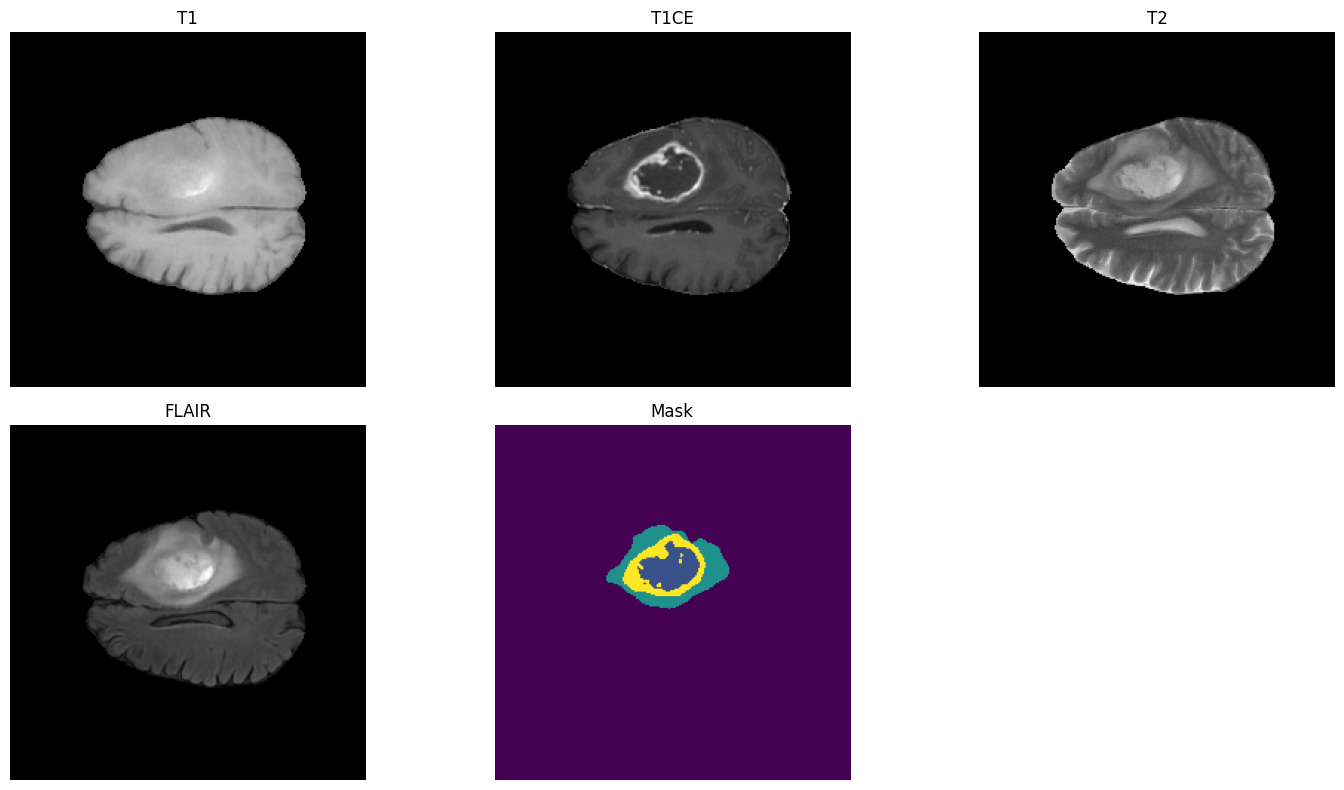

In [ ]:
import matplotlib.pyplot as plt
#Select Slice Index
slice_id = 95
#Print Slice Number
print("Slice Number:", slice_id)
#Create Figure
plt.figure(figsize=(15, 8))

# T1
#Create Subplot Grid
plt.subplot(2, 3, 1)
#Plot T1
plt.imshow(test_image_t1[:, :, slice_id], cmap='gray')
plt.title("T1")
plt.axis("off")

# T1ce
plt.subplot(2, 3, 2)
#Plot T1ce, T2, FLAIR
plt.imshow(test_image_t1ce[:, :, slice_id], cmap='gray')
plt.title("T1CE")
plt.axis("off")

# T2
plt.subplot(2, 3, 3)
#Plot T2
plt.imshow(test_image_t2[:, :, slice_id], cmap='gray')
plt.title("T2")
plt.axis("off")

# Flair
plt.subplot(2, 3, 4)
#Plot FLAIR
plt.imshow(test_image_flair[:, :, slice_id], cmap='gray')
plt.title("FLAIR")
plt.axis("off")

# Segmentation Mask
plt.subplot(2, 3, 5)
# Plot Segmentation Mask
plt.imshow(test_image_seg[:, :, slice_id])
plt.title("Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


Prints the shape of MRI images
, Prints the shape of segmentation masks
, Verifies that both match exactly

In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)


Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Converts a raw segmentation mask into one-hot encoded format
, Fixes label inconsistency (4 → 3)
, Prepares masks for multi-class training
, Makes them compatible with U-Net loss functions

In [ ]:
#Function Definition
def encode_segmentation_mask(mask_3d):
    """
    mask_3d: shape (H, W, D) with labels {0,1,2,4}
    returns: one-hot encoded mask (H, W, D, 4)
    """
    #Copy Mask
    mask = mask_3d.copy()
    #mask[mask == 4] = 3
    mask[mask == 4] = 3

    # Initialize One-Hot Array
    one_hot = np.zeros(mask.shape + (N_CLASSES,), dtype=np.uint8)
    #One-Hot Encoding Loop
    for c in range(N_CLASSES):
        one_hot[..., c] = (mask == c).astype(np.uint8)
    #Return Encoded Mask
    return one_hot


Visualizes MRI data in three anatomical planes
, Shows transverse, frontal, and sagittal views
, Helps understand tumor location in 3D
, Verifies volumetric consistency

Slice Number: 95


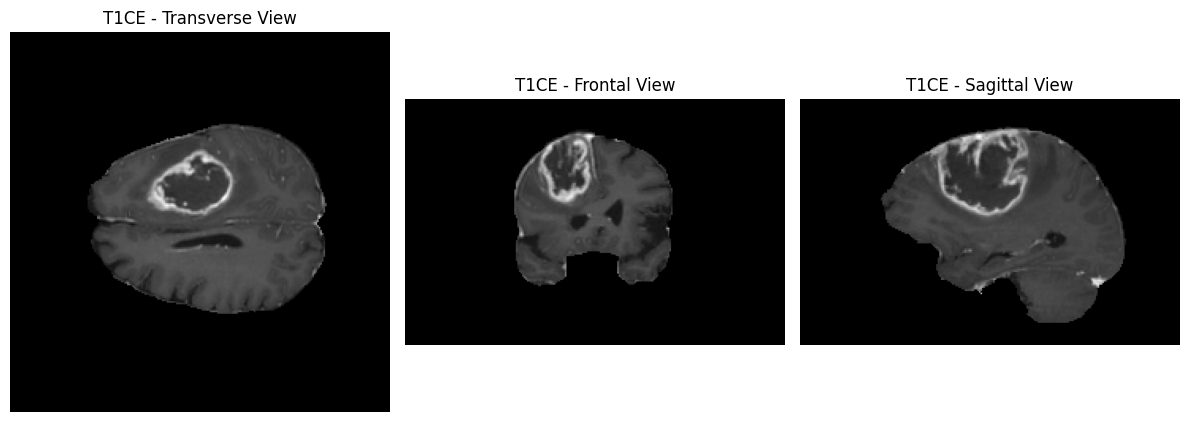

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#Select Slice
slice_id = 95
print("Slice Number:", slice_id)
#Create Figure
plt.figure(figsize=(12, 8))

# ---------- T1CE Transverse View ----------
plt.subplot(1, 3, 1)
#Transverse (Axial) View
plt.imshow(test_image_t1ce[:, :, slice_id], cmap="gray")
plt.title("T1CE - Transverse View")
plt.axis("off")

# ---------- T1CE Frontal View ----------
plt.subplot(1, 3, 2)
#Frontal (Coronal) View
plt.imshow(np.rot90(test_image_t1ce[:, slice_id, :], 1), cmap="gray")
plt.title("T1CE - Frontal View")
plt.axis("off")

# ---------- T1CE Sagittal View ----------
plt.subplot(1, 3, 3)
#Sagittal View
plt.imshow(np.rot90(test_image_t1ce[slice_id, :, :], 1), cmap="gray")
plt.title("T1CE - Sagittal View")
#Remove Axes
plt.axis("off")
#Layout + Show
plt.tight_layout()
plt.show()


In [ ]:
# Run this once (if scikit-image is not installed yet)
!pip install -q scikit-image


montage of all T1ce slices

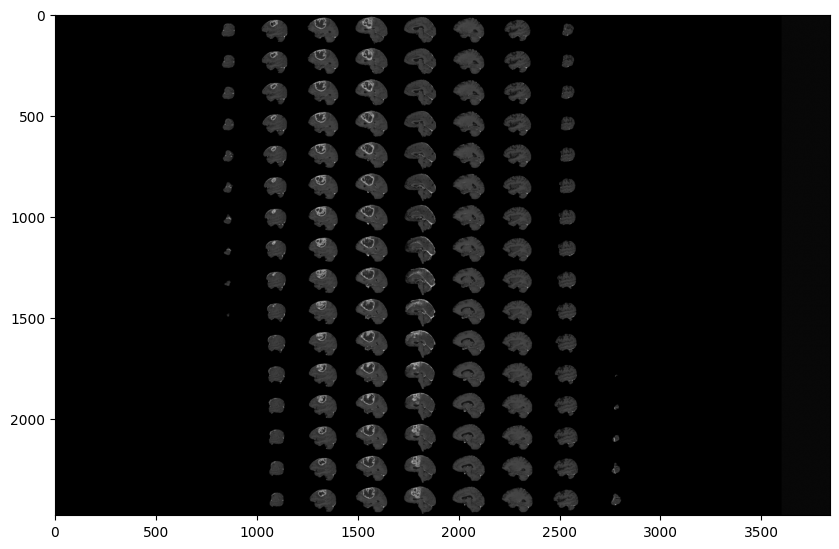

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size
# horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:, :, :]), 90, resize=True), cmap='gray');


montage of T1ce slices 50:-50


 Removes uninformative slices from the volume
Creates a montage of multiple MRI slices, Rotates for correct orientation
, Displays an overview image


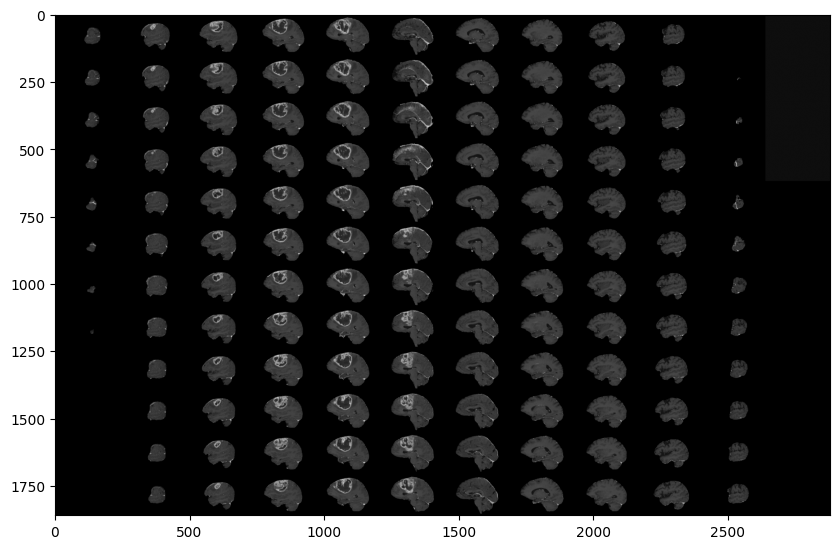

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
#Skip Uninformative Slices
plt.imshow(rotate(montage(test_image_t1ce[50:-50, :, :]), 90, resize=True),
           cmap='gray');


montage of segmentation (mask) slices 50:-50

Removes uninformative slices from the volume

Creates a montage of multiple MRI slices

Rotates for correct orientation

Displays an overview image

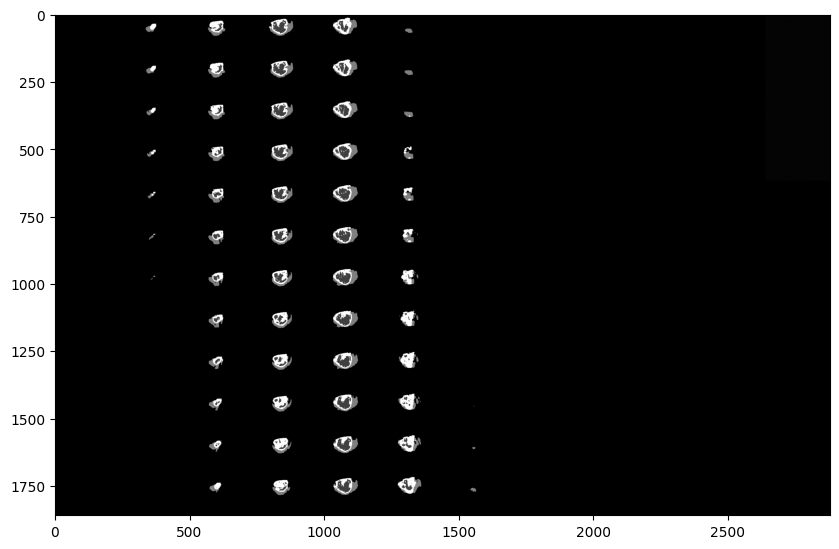

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
#Create montage,Rotate image
plt.imshow(rotate(montage(test_image_seg[50:-50, :, :]), 90, resize=True),
           cmap='gray');


Plotting the Segmentation Slice

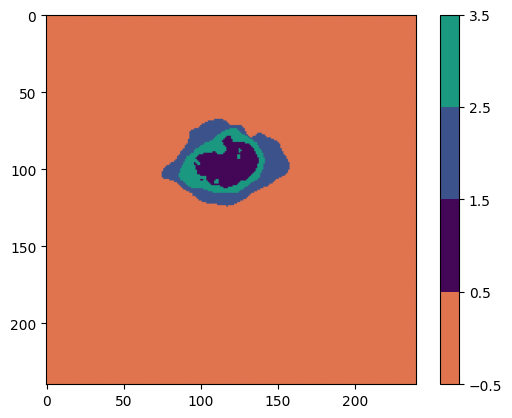

In [ ]:
# Plotting the segmentation
import matplotlib
#Create Custom Colormap
cmap = matplotlib.colors.ListedColormap(["#e0744f", "#440656", "#3b528b", "#1b9880"])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
#Plot Mask Slice
plt.imshow(test_image_seg[:, :, 95], cmap=cmap, norm=norm)
#Add Colorbar
plt.colorbar()
#Show Plot
plt.show()


Isolation of Classes

Separates each tumor class from the segmentation mask

Keeps only one class at a time

Hides all other classes using NaN

Prepares masks for class-wise visualization and analysis

In [ ]:
# Isolate Class 0 (Background)
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan


In [ ]:
slice = 95

Plot 1 Row × 5 Columns

Creates a legend for tumor classes

 Displays original segmentation + each isolated class

 Shows everything side-by-side

 Makes results easy to interpret

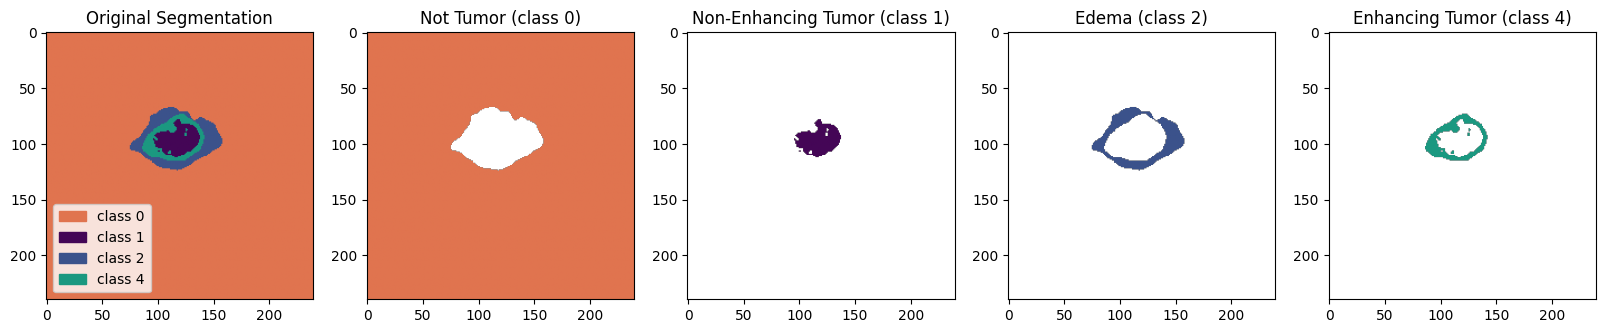

In [ ]:
# Define legend
#Create Class Names
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
#Create Legend Boxes
legend = [plt.Rectangle((0,0),1,1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]
#Create Subplots
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

#Plot Original Segmentation
ax[0].imshow(test_image_seg[:, :, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

#Plot Individual Classes
#Class 0
ax[1].imshow(seg_0[:, :, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')
#Class 1
ax[2].imshow(seg_1[:, :, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')
##Class 2
ax[3].imshow(seg_2[:, :, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')
#Class 3
ax[4].imshow(seg_4[:, :, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')
#Display Plot
plt.show()


Split the Dataset

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


Imports the function used to split data into train/validation/test sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Function: Extract IDs from Paths
def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):#Loops through all directory paths.
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
#Convert Paths to IDs
train_and_test_ids = pathListIntoIds(train_and_val_directories)
#First Split: Train + Test
train_ids, test_ids = train_test_split(train_and_test_ids, test_size=0.15)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.2)


Print data distribution (Train: 68%, Test: 12%, Val: 20%)

In [ ]:

#Print Training Size
print(f"Train length: {len(train_ids)}")
#Print Validation Size
print(f"Validation length: {len(val_ids)}")
#Print Test Size
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 63
Test length: 56


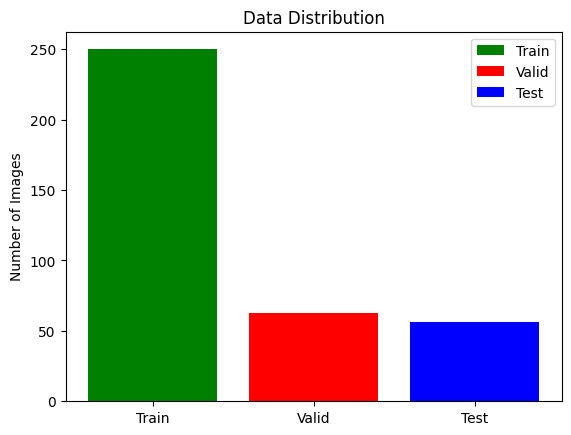

In [ ]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

DataGenerator Section

In [ ]:
#Define SEGMENT_CLASSES and image parameters
# Maps numeric labels → human-readable names
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [ ]:
#Import Libraries
import os
import nibabel as nib
#Define Function
def find_modalities(case_path):
    #Docstring
    """Return paths for t1, t1ce, t2, flair, seg inside one case folder.
       If a file is missing, returns None for that modality."""
    #List All Files
    files = os.listdir(case_path)
    #Inner Helper Function
    def find_one(keywords):
      #Loop Through Files
        for f in files:
            lower = f.lower()
            #Match Keywords
            if any(k in lower for k in keywords):
              #Return Path
                return os.path.join(case_path, f)
       #If Not Found
        return None
    #Find Each Modality
    t1_path    = find_one(["_t1."])       # _t1.nii or _t1.nii.gz
    t1ce_path  = find_one(["_t1ce."])
    t2_path    = find_one(["_t2."])
    flair_path = find_one(["_flair."])
    # seg / segm / Segm – anything that contains "seg"
    seg_path   = find_one(["seg"])
    #Return All Paths
    return t1_path, t1ce_path, t2_path, flair_path, seg_path


implemented a Keras Sequence generator to load BraTS volumes on-the-fly, extract central slices, normalize image intensities, preserve categorical masks with nearest-neighbor resizing, and output one-hot encoded targets for multi-class U-Net training.”

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from keras.utils import Sequence

# ----- global settings (keep consistent with the rest of notebook) -----
IMG_SIZE       = 128
VOLUME_SLICES  = 100
VOLUME_START   = 22          # first slice index to use
N_CHANNELS     = 2           # flair, t1ce, t2
N_CLASSES      = 4           # background, necrotic, edema, enhancing

# make sure this matches the one you printed at cell [165]
TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"


def find_modalities(case_path):
    """
    Returns full paths for t1, t1ce, t2, flair, seg inside a case folder.
    We look for substrings in the filenames.
    """
    files = os.listdir(case_path)

    def pick(substrs):
      #Loop Through Files
        for f in files:
          #Loop Through Keywords
            for s in substrs:
              #Check Match
                if s in f:
                  #Return Full Path
                    return os.path.join(case_path, f)
        #If No Match Found
        raise FileNotFoundError(f"Could not find file containing {substrs} in {case_path}")
    #Find Modalities
    t1_path    = pick(["_t1."])
    t1ce_path  = pick(["_t1ce."])
    t2_path    = pick(["_t2."])
    flair_path = pick(["_flair."])
    seg_path   = pick(["_seg.", "_segm", "_Segm"])

    return t1_path, t1ce_path, t2_path, flair_path, seg_path

#Class Definition
class DataGenerator(Sequence):
  #Constructor
    def __init__(self,
                 list_IDs,
                 batch_size=1,
                 dim=(IMG_SIZE, IMG_SIZE),
                 n_channels=N_CHANNELS,
                 n_classes=N_CLASSES,
                 shuffle=True):
        #Assign Attributes
        self.list_IDs   = list_IDs
        self.batch_size = batch_size
        self.dim        = dim
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        #Epoch End Hook
        self.on_epoch_end()

    # how many batches per epoch
    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    # generate one batch
    def __getitem__(self, index):
        # indexes of the cases in this batch
        indexes   = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]

        X, Y = self._data_generation(batch_ids)
        return X, Y

    # shuffle after each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # helper to load and normalise a volume
    def _load_volume(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Volume file not found: {filepath}")
        vol = nib.load(filepath).get_fdata().astype(np.float32)
        m = vol.max()
        if m > 0:
            vol /= m
        return vol

    # main data generation
    def _data_generation(self, batch_ids):
        # each case -> VOLUME_SLICES slices
        X = np.zeros(
            (self.batch_size * VOLUME_SLICES, self.dim[0], self.dim[1], self.n_channels),
            dtype=np.float32
        )
        Y = np.zeros(
            (self.batch_size * VOLUME_SLICES, self.dim[0], self.dim[1], self.n_classes),
            dtype=np.float32
        )

        idx = 0  # position inside X/Y

        for case_id in batch_ids:
            case_path = os.path.join(TRAIN_DATASET_PATH, case_id)

            if not os.path.isdir(case_path):
                raise FileNotFoundError(f"Case folder not found: {case_path}")

            t1_path, t1ce_path, t2_path, flair_path, seg_path = find_modalities(case_path)

            # load volumes
            flair_vol = self._load_volume(flair_path)
            t1ce_vol  = self._load_volume(t1ce_path)


            if not os.path.exists(seg_path):
                raise FileNotFoundError(f"Segmentation file not found: {seg_path}")
            seg_vol   = nib.load(seg_path).get_fdata().astype(np.uint8)  # labels 0..3/4

            # fill slices
            for j in range(VOLUME_SLICES):
                slice_idx = VOLUME_START + j

                # X channels (resized to 128x128)
                X[idx, :, :, 0] = cv2.resize(flair_vol[:, :, slice_idx], self.dim, interpolation=cv2.INTER_LINEAR)
                X[idx, :, :, 1] = cv2.resize(t1ce_vol[:,   :, slice_idx], self.dim, interpolation=cv2.INTER_LINEAR)


                # mask slice (nearest neighbour, keep labels as ints)
                mask = cv2.resize(seg_vol[:, :, slice_idx], self.dim, interpolation=cv2.INTER_NEAREST).astype(np.uint8)

                # one-hot encode into 4 channels
                for c in range(self.n_classes):
                    Y[idx, :, :, c] = (mask == c).astype(np.float32)

                idx += 1

        return X, Y


In [ ]:
NUM_CHANNELS = 2


Loads all BraTS case folders, splits them into training and validation sets, and initializes custom Keras data generators to feed MRI slices into the segmentation model.

In [ ]:
# === 1. Load list of case folders ===
import os
#Define Dataset Path
TRAIN_DATASET_PATH = "/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"   # ← change if different
#Load All Case Folders
all_cases = sorted([
    d for d in os.listdir(TRAIN_DATASET_PATH)
    if d.startswith("BraTS20_Training_")
])

print("Total cases found:", len(all_cases))

# === 2. Split into training/validation ===
train_ids = all_cases[:200]      # FIRST 200 for training
val_ids   = all_cases[200:230]   # NEXT 30 for validation

print("Train:", len(train_ids), " Validation:", len(val_ids))

# === 3. Create generator objects ===
BATCH_SIZE = 1

train_gen = DataGenerator(
    list_IDs=train_ids,
    batch_size=BATCH_SIZE,
    dim=(IMG_SIZE, IMG_SIZE),
    n_channels=NUM_CHANNELS,
    shuffle=True
)
#Create Validation Generator
val_gen = DataGenerator(
    list_IDs=val_ids,
    batch_size=BATCH_SIZE,
    dim=(IMG_SIZE, IMG_SIZE),
    n_channels=NUM_CHANNELS,
    shuffle=False
)
#Confirmation Message
print("Generators created successfully!")


Total cases found: 369
Train: 200  Validation: 30
Generators created successfully!


Validates the data generator by creating a small train/validation split and inspecting the shape, type, and label values of one generated batch before full model training.

In [ ]:
#Verify Dataset
print("Number of cases:", len(all_cases))
print("First 3:", all_cases[:3])

# Small Debug Split
train_ids = all_cases[:2]
val_ids   = all_cases[2:4]
#Initialize Generators
train_generator = DataGenerator(train_ids, batch_size=1)
val_generator   = DataGenerator(val_ids,   batch_size=1)

# test one batch
X_batch, Y_batch = train_generator[0]
#Check Input Batch
print("X_batch:", X_batch.shape, X_batch.dtype)
print("Y_batch:", Y_batch.shape, Y_batch.dtype)
print("Unique labels in first mask slice:", np.unique(Y_batch[0]))


Number of cases: 369
First 3: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003']
X_batch: (100, 128, 128, 2) float32
Y_batch: (100, 128, 128, 4) float32
Unique labels in first mask slice: [0. 1.]


Defines a visualization function to display MRI modalities (FLAIR, T1CE) and their corresponding segmentation mask side by side for qualitative inspection.

In [ ]:
#Import Plotting Library
import matplotlib.pyplot as plt
#Define Visualization Function
def display_slice_and_segmentation(flair_slice, t1ce_slice, seg_slice):
  #Documentation String
    """Display FLAIR, T1CE, and segmentation mask side by side."""
    #Create Figure
    plt.figure(figsize=(15, 5))

    # Display FLAIR Image
    plt.subplot(1, 3, 1)
    plt.imshow(flair_slice, cmap='gray')
    plt.title("FLAIR")
    plt.axis("off")

    # Display T1CE Image
    plt.subplot(1, 3, 2)
    plt.imshow(t1ce_slice, cmap='gray')
    plt.title("T1CE")
    plt.axis("off")

    # SDisplay Segmentation Mask
    plt.subplot(1, 3, 3)
    plt.imshow(seg_slice, cmap='nipy_spectral')
    plt.title("Segmentation")
    plt.axis("off")

    plt.show()


Defines Dice coefficient and Dice loss functions for evaluating and optimizing multi-class brain tumor segmentation performance.

In [ ]:
#Import Keras Backend
import tensorflow as tf
from tensorflow.keras import backend as K

# -------------------------------------------------------
# Dice coefficient for ONE class
# -------------------------------------------------------
#Dice Coefficient Function
def dice_coef(y_true, y_pred, smooth=1e-10):
    #Flatten Inputs
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #Compute Intersection
    intersection = K.sum(y_true_f * y_pred_f)
    #Dice Formula
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# -------------------------------------------------------
# Dice loss for MULTI-CLASS segmentation (BraTS has 4 classes)
# -------------------------------------------------------
#Dice Loss Function (Multi-Class
def dice_loss(y_true, y_pred, smooth=1e-10):
  #Number of Classes
    class_num = y_pred.shape[-1]   # number of classes (usually 4)
    #Initialize Loss
    total_loss = 0.0
    #Loop Over Classes
    for i in range(class_num):
      #Class-wise Dice Loss
        loss = 1 - dice_coef(y_true[..., i], y_pred[..., i], smooth)
        #Accumulate Loss
        total_loss += loss
    #Average Over Classes
    return total_loss / class_num     # average loss over classes


Defines class-specific Dice coefficients and a combined Dice loss to evaluate and optimize segmentation performance separately for different tumor sub-regions.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# ----- Define per-class Dice coefficient -----
#Dice for Necrotic Region
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    #Extract Class Channel   class 0 → necrotic
    y_true_f = K.flatten(y_true[..., 1])
    y_pred_f = K.flatten(y_pred[..., 1])
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    # Extract Class Channel class 1 → edema
    y_true_f = K.flatten(y_true[..., 2])
    y_pred_f = K.flatten(y_pred[..., 2])
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    #Extract Class Channel  class 2 → enhancing tumor
    y_true_f = K.flatten(y_true[..., 3])
    y_pred_f = K.flatten(y_pred[..., 3])
    #Compute Intersection
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    #Dice Formula (Squared Version)
    return (2. * intersection + epsilon) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + epsilon)

# ----- Combined Weighted Dice Loss (optional) -----

def total_dice_loss(y_true, y_pred):
  #Individual Losses
    loss_ncr = 1 - dice_coef_necrotic(y_true, y_pred)
    loss_ed  = 1 - dice_coef_edema(y_true, y_pred)
    loss_en  = 1 - dice_coef_enhancing(y_true, y_pred)
    return (loss_ncr + loss_ed + loss_en) / 3.0


Implements custom evaluation metrics (precision, sensitivity/recall, specificity) using Keras backend to monitor segmentation performance beyond Dice score, especially for medical false-positive/false-negative trade-offs.

In [ ]:
# ----------------- EVALUATION METRICS -----------------

# Computing Precision
def precision(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_pos = K.round(K.clip(y_true, 0, 1))

    true_positives      = K.sum(y_true_pos * y_pred_pos)
    predicted_positives = K.sum(y_pred_pos)

    return true_positives / (predicted_positives + K.epsilon())


# Computing Sensitivity (Recall)
def sensitivity(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_pos = K.round(K.clip(y_true, 0, 1))

    true_positives    = K.sum(y_true_pos * y_pred_pos)
    possible_positives = K.sum(y_true_pos)

    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    y_pred_neg = K.round(K.clip(1 - y_pred, 0, 1))
    y_true_neg = K.round(K.clip(1 - y_true, 0, 1))

    true_negatives    = K.sum(y_true_neg * y_pred_neg)
    possible_negatives = K.sum(y_true_neg)

    return true_negatives / (possible_negatives + K.epsilon())


 Define the Segmentation Model

U-Net¶
We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans.

Since the BraTS2020 dataset consists of 3D images, with each image comprising multiple 2D slices in three orthogonal planes, we have two options: using a 2D U-Net or a 3D U-Net.

3D U-Net: More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.
2D U-Net: Faster and requires less memory, advantageous when working with large datasets or limited computational resources.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
)
from tensorflow.keras.models import Model

def build_unet(input_shape, ker_init="he_normal", dropout=0.2):
    """
    Build a 2D U-Net for multi-class segmentation.

    Args:
        input_shape: Tuple like (IMG_SIZE, IMG_SIZE, channels). Example: (128, 128, 2)
                     where channels could be MRI modalities (e.g., FLAIR + T1CE).
        ker_init: Kernel initializer. 'he_normal' is a good default for ReLU networks.
        dropout: Dropout rate used in deeper layers to reduce overfitting.

    Returns:
        A Keras Model implementing U-Net with softmax output for 4 classes.
    """

    # Input layer for multi-modal MRI slices
    inputs = Input(input_shape, name="input_layer")

    # =========================================================
    # ENCODER (Contracting path)
    # Each block: Conv -> Conv -> MaxPool
    # Purpose: extract hierarchical features while reducing spatial resolution.
    # =========================================================

    # Encoder block 1 (highest resolution)
    conv1 = Conv2D(32, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Encoder block 2
    conv2 = Conv2D(64, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Encoder block 3
    conv3 = Conv2D(128, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Encoder block 4 (deeper features + dropout for regularization)
    conv4 = Conv2D(256, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # =========================================================
    # BOTTLENECK (Lowest resolution, highest semantic features)
    # =========================================================
    conv5 = Conv2D(512, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # =========================================================
    # DECODER (Expanding path)
    # Each block: UpSample -> Conv -> Concatenate(skip) -> Conv -> Conv
    # Purpose: recover spatial resolution and refine boundaries.
    # Skip connections help preserve fine details (important in segmentation).
    # =========================================================

    # Decoder block 1
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(256, 3, activation="relu", padding="same",
                 kernel_initializer=ker_init)(up6)
    merge6 = Concatenate(axis=3)([drop4, up6])  # skip connection
    conv6 = Conv2D(256, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv6)

    # Decoder block 2
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 3, activation="relu", padding="same",
                 kernel_initializer=ker_init)(up7)
    merge7 = Concatenate(axis=3)([conv3, up7])  # skip connection
    conv7 = Conv2D(128, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv7)

    # Decoder block 3
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 3, activation="relu", padding="same",
                 kernel_initializer=ker_init)(up8)
    merge8 = Concatenate(axis=3)([conv2, up8])  # skip connection
    conv8 = Conv2D(64, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv8)

    # Decoder block 4 (back to original resolution)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(32, 3, activation="relu", padding="same",
                 kernel_initializer=ker_init)(up9)
    merge9 = Concatenate(axis=3)([conv1, up9])  # skip connection
    conv9 = Conv2D(32, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation="relu", padding="same",
                   kernel_initializer=ker_init)(conv9)

    # =========================================================
    # OUTPUT LAYER
    # 1x1 convolution converts feature maps to class probabilities per pixel.
    # Softmax outputs a probability distribution across 4 classes.
    # =========================================================
    conv10 = Conv2D(4, (1, 1), activation="softmax", name="output_layer")(conv9)

    # Build model object
    model = Model(inputs=inputs, outputs=conv10, name="UNet")
    return model


 Define training callbacks to control learning rate, save the best model,
and log training history for monitoring and reproducibility.


In [ ]:
from tensorflow.keras.utils import plot_model

IMG_SIZE = 128
N_CLASSES = 4           # 4 tumour classes
N_CHANNELS = 2


input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# Build U-Net model
model = build_unet(input_shape, ker_init='he_normal', dropout=0.2)

# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=N_CLASSES),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing,
    ],
)



Set up callbacks

callbacks to control training dynamics. ReduceLROnPlateau adapts the learning rate when validation loss stagnates, ModelCheckpoint saves the best-performing model, and CSVLogger records training metrics for analysis and reproducibility.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# ---- Set up callbacks (same as teacher, but filename fixed) ----
callbacks = [
    # 1) Reduce learning rate when val_loss stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-3,
        verbose=1
    ),

    # 2) Save only the best model (lowest val_loss)
    ModelCheckpoint(
        filepath='tumor_segmentation_model.weights.h5',  # <- must end with ".weights.h5"
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),

    # 3) Log training to a CSV file
    CSVLogger(
        'training_log.csv',
        separator=',',
        append=False
    )
]


Load the saved model

 Train the U-Net model using data generators with validation monitoring
 and adaptive callbacks for optimal performance.


In [ ]:
EPOCHS = 15

In [ ]:
#Start Training
history = model.fit(
    #Training Data
    train_gen,
    #Validation Data
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9636 - dice_coef: 0.9170 - dice_coef_edema: 0.0948 - dice_coef_enhancing: 0.0291 - dice_coef_necrotic: 0.0301 - loss: 1.0507 - mean_io_u: 0.5316 - precision: 0.9779 - sensitivity: 0.9290 - specificity: 0.9928
Epoch 1: val_loss improved from inf to 0.04438, saving model to tumor_segmentation_model.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1058s 5s/step - accuracy: 0.9637 - dice_coef: 0.9172 - dice_coef_edema: 0.0952 - dice_coef_enhancing: 0.0291 - dice_coef_necrotic: 0.0302 - loss: 1.0488 - mean_io_u: 0.5321 - precision: 0.9779 - sensitivity: 0.9293 - specificity: 0.9928 - val_accuracy: 0.9894 - val_dice_coef: 0.9685 - val_dice_coef_edema: 0.2903 - val_dice_coef_enhancing: 1.2289e-05 - val_dice_coef_necrotic: 0.0942 - val_loss: 0.0444 - val_mean_io_u: 0.7683 - val_precision: 0.9864 - val_sensitivity: 0.9880 - val_specificity: 0.9955 - learning_rate: 0.0010
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9

 Save the complete trained U-Net model (architecture + weights)
for later inference, evaluation, or deployment.


In [ ]:
# Save full model (architecture + weights)
model.save("my_model.keras")
#Confirmation Message
print("Model saved as my_model.keras")


Model saved as my_model.keras


Load the trained model

Load the saved U-Net model with custom loss functions and metrics
 for evaluation and inference.

In [ ]:

#Import Libraries from tensorflow import keras
import tensorflow as tf

# Load the save (trained) model
model = keras.models.load_model(
    #Path to Model
    "/content/my_model.keras",
    custom_objects={
        #Register Metrics & Losses
        "dice_coef": dice_coef,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "dice_coef_necrotic": dice_coef_necrotic,
        "dice_coef_edema": dice_coef_edema,
        "dice_coef_enhancing": dice_coef_enhancing,
        # MeanIoU that you used in model.compile
        "mean_io_u": tf.keras.metrics.MeanIoU(num_classes=4),
    },
    compile=False,
)
#Confirmation
print("Model loaded successfully!")
model.summary()


Model loaded successfully!


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ dropout_1[0][0] 

 Total params: 8,630,308 (32.92 MB)

 Trainable params: 8,630,308 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

Read the training_log.csv

 Load training history from CSV file for performance analysis and visualization


In [ ]:
import pandas as pd
#Load Training Log
history = pd.read_csv("/content/training_log.csv", sep=",", engine="python")
#Copy History
hist = history
#Preview Data
hist.head()


,epoch,accuracy,dice_coef,dice_coef_edema,dice_coef_enhancing,dice_coef_necrotic,learning_rate,loss,mean_io_u,precision,...,val_accuracy,val_dice_coef,val_dice_coef_edema,val_dice_coef_enhancing,val_dice_coef_necrotic,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
0,0,0.980555,0.956966,0.160823,0.019178,0.057895,0.001,0.669115,0.621744,0.980906,...,0.989361,0.968481,0.290300,0.000012,0.094234,0.044379,0.768317,0.986366,0.988012,0.995478
1,1,0.983950,0.974443,0.222426,0.135671,0.090067,0.001,0.106660,0.809835,0.981756,...,0.982742,0.949697,0.317887,0.000007,0.046823,0.067681,0.822240,0.984078,0.977249,0.994844
2,2,0.977973,0.970100,0.201679,0.091799,0.020424,0.001,11.340620,0.779201,0.974939,...,0.988634,0.971910,0.181781,0.000367,0.015060,0.048421,0.811786,0.983861,0.988569,0.994632
3,3,0.983768,0.975718,0.159672,0.051093,0.029241,0.001,0.935456,0.620291,0.980314,...,0.988634,0.969830,0.168468,0.000086,0.082291,0.051961,0.395396,0.983861,0.988569,0.994632
4,4,0.983319,0.974156,0.125341,0.104255,0.062089,0.001,27.818571,0.621451,0.980156,...,0.983096,0.956097,0.306708,0.000072,0.114686,0.060713,0.784817,0.985079,0.976582,0.995164


Predict Tumor Segmentations

In [ ]:
# Rebuild the exact U-Net architecture so we can restore a weights-only checkpoint.
# (Weights files do not include the model graph, so the structure must match 100%.)
IMG_SIZE   = 128
N_CHANNELS = 2  # MRI modalities used as input channels (e.g., FLAIR + T1CE)

input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
best_saved_model = build_unet(input_shape, ker_init="he_normal", dropout=0.2)

# Compile with the same loss/optimizer/metrics used during training.
# This is needed to run evaluation (and to continue training if required).
best_saved_model.compile(
    loss="categorical_crossentropy",  # multi-class pixel-wise segmentation with one-hot masks
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # stable default for U-Net training
    metrics=[
        "accuracy",            # pixel accuracy (can be misleading with class imbalance)
        dice_coef,             # overall overlap metric (important for medical segmentation)
        precision,             # controls false positives
        sensitivity,           # recall: controls false negatives (critical in tumor detection)
        specificity,           # true negative rate (healthy tissue correctness)
        dice_coef_necrotic,    # class-wise Dice for necrotic/core region
        dice_coef_edema,       # class-wise Dice for edema region
        dice_coef_enhancing,   # class-wise Dice for enhancing tumor region
    ],
)

# Load the "best" weights saved during training (e.g., lowest validation loss checkpoint).
# If the architecture or input_shape differs, this step will fail due to shape mismatches.
best_saved_model.load_weights("tumor_segmentation_model.weights.h5")

)

# Load the best saved weights
best_saved_model.load_weights("tumor_segmentation_model.weights.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import nibabel as nib
import numpy as np
import cv2

# Assumes these are already defined (same as training):
# IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, N_CHANNELS

def imageLoader(flair_path, t1ce_path):
    """
    Load one BraTS case (FLAIR + T1CE), preprocess it,
    and return data ready for model.predict().

    Parameters
    ----------
    flair_path : str
        Path to FLAIR MRI volume (.nii or .nii.gz)
    t1ce_path : str
        Path to T1CE MRI volume (.nii or .nii.gz)

    Returns
    -------
    X : np.ndarray
        Shape: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    """

    # Load 3D MRI volumes
    flair_vol = nib.load(flair_path).get_fdata()
    t1ce_vol  = nib.load(t1ce_path).get_fdata()

    # Allocate output array
    X = np.zeros(
        (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CHANNELS),
        dtype=np.float32
    )

    # Extract slices
    for j in range(VOLUME_SLICES):

        # Select slice index (skip empty borders)
        slice_idx = j + VOLUME_START_AT

        # Channel 0 → FLAIR
        X[j, :, :, 0] = cv2.resize(
            flair_vol[:, :, slice_idx],
            (IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_LINEAR
        )

        # Channel 1 → T1CE
        X[j, :, :, 1] = cv2.resize(
            t1ce_vol[:, :, slice_idx],
            (IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_LINEAR
        )

    # Normalize intensity (same as training)
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    return X


In [ ]:
# ---------- 1. Helper: load a 3-D NIfTI volume (.nii) ----------

import nibabel as nib
import numpy as np
import cv2

# We assume these are already defined above, same as in training:
# IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, N_CHANNELS

def imageLoader(flair_path, t1ce_path):
    """
    Load one BraTS case (FLAIR + T1ce), extract VOLUME_SLICES slices,
    resize to IMG_SIZE and return an array ready for model.predict.

    Returns
    -------
    X : np.ndarray
        Shape (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    """
    # load the 3D volumes
    flair_vol = nib.load(flair_path).get_fdata()
    t1ce_vol  = nib.load(t1ce_path).get_fdata()

    # allocate output
    X = np.zeros(
        (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CHANNELS),
        dtype=np.float32
    )

    # fill slice by slice
    for j in range(VOLUME_SLICES):
        slice_idx = j + VOLUME_START_AT

        # channel 0 = FLAIR
        X[j, :, :, 0] = cv2.resize(
            flair_vol[:, :, slice_idx],
            (IMG_SIZE, IMG_SIZE)
        )

        # channel 1 = T1ce
        X[j, :, :, 1] = cv2.resize(
            t1ce_vol[:, :, slice_idx],
            (IMG_SIZE, IMG_SIZE)
        )

    # normalise like during training (divide by max intensity)
    max_val = X.max()
    if max_val > 0:
        X /= max_val

    return X



# ---------- 2. Optional helper: load many images + masks from a directory ----------

def loadDataFromDir(path, list_of_files, mriType, n_images):
    """
    Load slices and corresponding masks for a list of subjects.

    This helper is mainly for creating extra datasets (not strictly needed
    for the final prediction visualisation, but we keep it like in the
    original notebook).

    Parameters
    ----------
    path : str
        Base folder that contains the case folders (not directly used here,
        but kept for consistency with the original code).
    list_of_files : list of str
        List of paths to individual case folders.
    mriType : str
        Part of the filename that indicates the MRI modality
        (e.g. 'flair', 't1ce', ...).
    n_images : int
        How many case folders from list_of_files to load.

    Returns
    -------
    scans : np.ndarray
        4-D array (N_slices, IMG_SIZE, IMG_SIZE, 1) with input images.
    masks : np.ndarray
        4-D array (N_slices, IMG_SIZE, IMG_SIZE, 1) with segmentation masks.
    """
    scans = []   # will store each 2-D slice of the MRI volume
    masks = []   # will store the corresponding 2-D mask slice

    # Loop over the first n_images case folders
    for i in list_of_files[:n_images]:

        # Find the MRI volume of the given type inside this case folder
        fullPath = glob.glob(i + '/*' + mriType + '*')[0]
        # Load the MRI volume as 3-D array (H, W, D)
        currentScanVolume = imageLoader(fullPath)

        # Find the segmentation volume (*seg*) for this case
        currentMaskVolume = imageLoader(glob.glob(i + '/*seg*')[0])

        # For each axial slice in this 3-D volume
        for j in range(0, currentScanVolume.shape[2]):

            # Take slice j from the MRI, resize to (IMG_SIZE, IMG_SIZE)
            scan_img = cv2.resize(
                currentScanVolume[:, :, j],
                dsize=(IMG_SIZE, IMG_SIZE),
                interpolation=cv2.INTER_AREA
            ).astype('uint8')

            # Take slice j from the mask, same resizing
            mask_img = cv2.resize(
                currentMaskVolume[:, :, j],
                dsize=(IMG_SIZE, IMG_SIZE),
                interpolation=cv2.INTER_AREA
            ).astype('uint8')

            # Add an extra channel dimension at the end -> (H, W, 1)
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])

    # Convert lists to numpy arrays of type float32 (what Keras expects)
    return (
        np.array(scans, dtype='float32'),
        np.array(masks, dtype='float32')
    )



# ---------- 3. Make predictions for one case (one subject) ----------

def predictByPath(case_path, case):
    """
    Build the input volume (stack of 2-D slices) for a single case and
    run the trained U-Net on it.

    Parameters
    ----------
    case_path : str
        Path to the folder for this case, e.g.
        '/content/drive/.../BraTS20_Training_001'
    case : str
        Case ID without the 'BraTS20_Training_' prefix, e.g. '001'.

    Returns
    -------
    np.ndarray
        4-D array (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CLASSES)
        with softmax probabilities for each class.
    """

    # Get the list of files in this case folder (not strictly needed
    # later, but kept like in the original notebook)
    files = next(os.walk(case_path))[2]

    # Allocate empty array for the network input:
    # VOLUME_SLICES slices, each slice is 128x128, and we use 2 channels:
    #   channel 0 -> FLAIR
    #   channel 1 -> T1CE
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2), dtype=np.float32)

    # ---- Load FLAIR volume ----
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    # ---- Load T1CE volume ----
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    # Build the input tensor slice-by-slice
    for j in range(VOLUME_SLICES):
        # Index in original volume: j + VOLUME_START_AT (skip initial slices)
        z = j + VOLUME_START_AT

        # Resize that slice from the 3-D volume to network input size
        X[j, :, :, 0] = cv2.resize(flair[:, :, z], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, z],    (IMG_SIZE, IMG_SIZE))

    # Normalise intensities to [0, 1] by dividing by the max value in X
    X_norm = X / np.max(X)

    # Use the trained model to predict probabilities for each class
    # (Here `model` should be your best-saved model; in your notebook
    # you either reloaded it from 'my_model.keras' or built it again
    # and loaded 'tumor_segmentation_model.weights.h5'.)
    return model.predict(X_norm, verbose=1)



# ---------- 4. Visualise predictions for one case ----------

def showPredictsById(case, start_slice=60):
    """
    Display original MRI, ground-truth mask, and predicted masks
    for a given case ID.

    Parameters
    ----------
    case : str
        Case ID without the 'BraTS20_Training_' prefix (e.g. '001').
    start_slice : int
        Index (within the 22 selected slices) of the slice to display.
        Default is 60 in the original notebook (relative to full volume),
        but here we treat it as an index in the cropped part + VOLUME_START_AT.
    """

    # Folder that contains all volumes for this case
    path = (
        f"/content/drive/MyDrive/archive/BraTS2020_TrainingData/"
        f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    )

    # ---- Load ground-truth segmentation volume ----
    gt = nib.load(
        os.path.join(path, f'BraTS20_Training_{case}_seg.nii')
    ).get_fdata()

    # ---- Load original FLAIR volume (for background image) ----
    origImage = nib.load(
        os.path.join(path, f'BraTS20_Training_{case}_flair.nii')
    ).get_fdata()

    # ---- Get model predictions for this case ----
    p = predictByPath(path, case)

    # Split probability volume into separate class volumes
    # p has shape (VOLUME_SLICES, H, W, 4); index 0 is background,
    # 1 = necrotic/core, 2 = edema, 3 = enhancing.
    core      = p[:, :, :, 1]
    edema     = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Create a figure with 1 row and 6 columns of subplots
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # Choose the actual z-index in the full 3-D volume
    z_full = start_slice + VOLUME_START_AT

    # For each panel, first draw the grayscale brain background
    for i in range(6):
        axarr[i].imshow(
            cv2.resize(origImage[:, :, z_full], (IMG_SIZE, IMG_SIZE)),
            cmap="gray",
            interpolation="none"
        )

    # ---- 0: Original FLAIR slice ----
    axarr[0].imshow(
        cv2.resize(origImage[:, :, z_full], (IMG_SIZE, IMG_SIZE)),
        cmap="gray"
    )
    axarr[0].title.set_text('Original image flair')

    # ---- 1: Ground-truth segmentation (all tumour) ----
    curr_gt = cv2.resize(
        gt[:, :, z_full],
        (IMG_SIZE, IMG_SIZE),
        interpolation=cv2.INTER_NEAREST
    )
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation="none", alpha=0.3)
    axarr[1].title.set_text('Ground truth')

    # ---- 2: All predicted classes stacked together ----
    axarr[2].imshow(
        p[start_slice, :, :, 1:4],  # probabilities of tumour classes
        cmap="Reds",
        interpolation="none",
        alpha=0.3
    )
    axarr[2].title.set_text('all classes predicted')

    # ---- 3: Edema only ----
    axarr[3].imshow(
        edema[start_slice, :, :],
        cmap="OrRd",
        interpolation="none",
        alpha=0.3
    )
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

    # ---- 4: Necrotic / core only ----
    axarr[4].imshow(
        core[start_slice, :, :],
        cmap="OrRd",
        interpolation="none",
        alpha=0.3
    )
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

    # ---- 5: Enhancing tumour only ----
    axarr[5].imshow(
        enhancing[start_slice, :, :],
        cmap="OrRd",
        interpolation="none",
        alpha=0.3
    )
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 676ms/step


<Figure size 1800x5000 with 0 Axes>

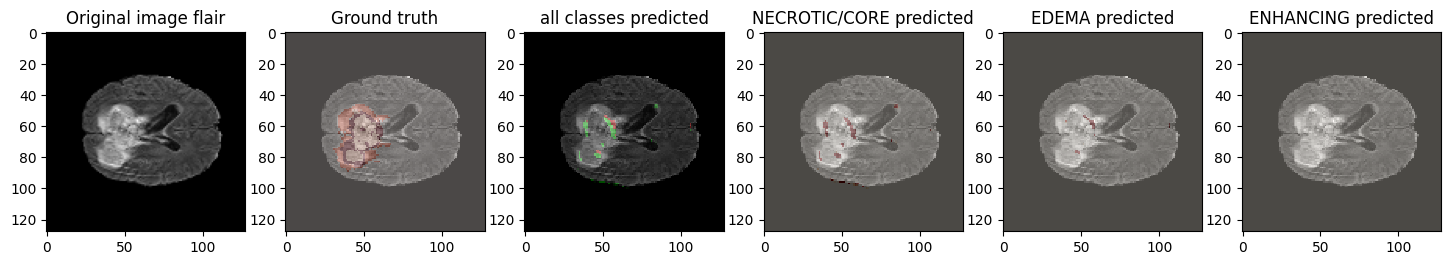

In [ ]:
showPredictsById(case=test_ids[0][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

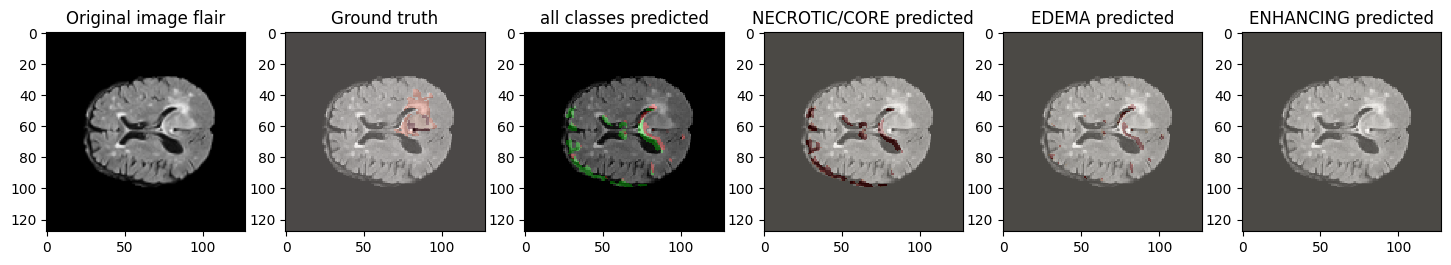

In [ ]:
showPredictsById(case=test_ids[1][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

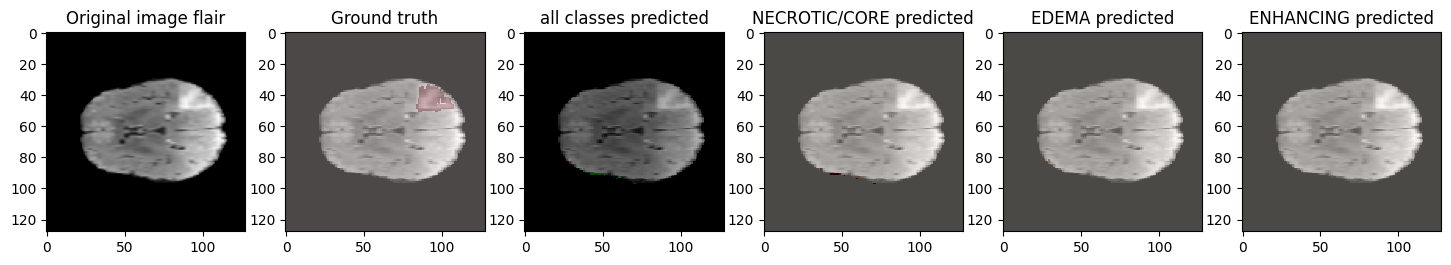

In [ ]:
showPredictsById(case=test_ids[2][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

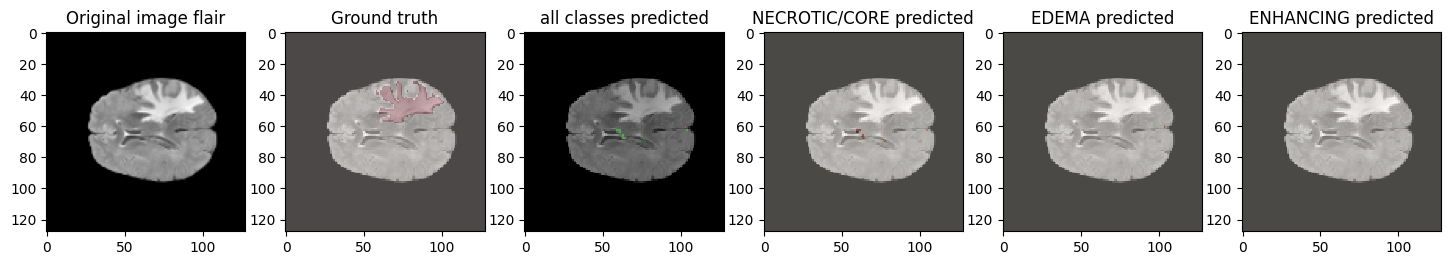

In [ ]:
showPredictsById(case=test_ids[3][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

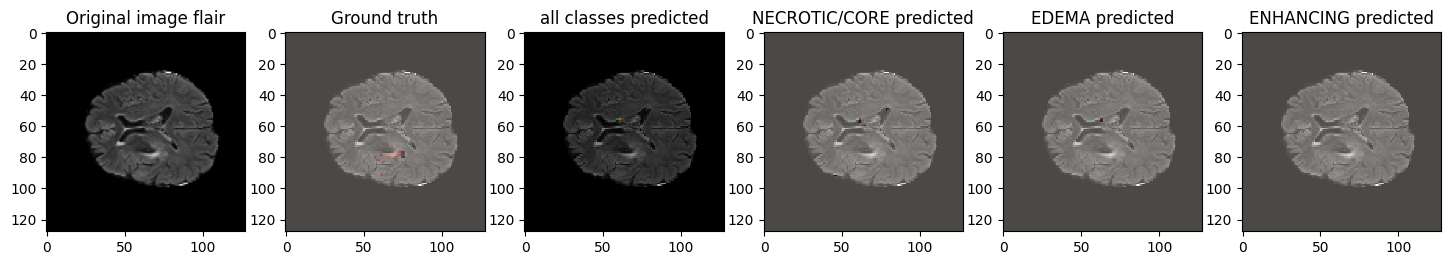

In [ ]:
showPredictsById(case=test_ids[4][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

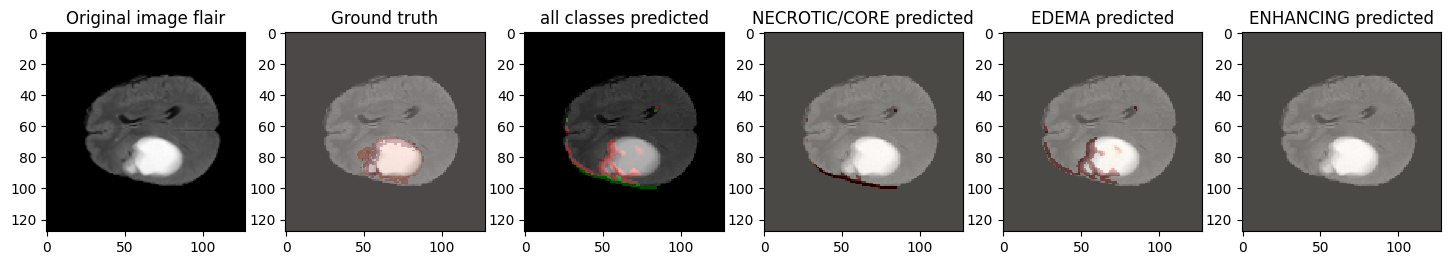

In [ ]:
showPredictsById(case=test_ids[5][-3:])

 Load MRI scans, preprocess them, and run the trained U-Net model
 to generate tumor segmentation predictions for a new patient.

In [ ]:
def predict_segmentation(sample_path):
    # Load NIFTI (.nii) scans for this patient
    t1ce_path  = sample_path + "_t1ce.nii"
    flair_path = sample_path + "_flair.nii"

    # Extract array data from nii files
    t1ce  = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Prepare empty array for resized slices (2 channels)
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as in training
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce [:,:, j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize & predict
    return best_saved_model.predict(X / np.max(X), verbose=1)


 Define normalization for segmentation mask values (0–3) to map them correctly to colors


In [ ]:
from matplotlib.colors import Normalize

# This normalization is needed for segmentation masks (0–3)
cmap_norm = Normalize(vmin=0, vmax=3)



 Function to load MRI scans, preprocess them like training data, and predict tumor segmentation


In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

         # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)



In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    """
    Randomly pick one patient, run segmentation prediction for a chosen slice,
    and visualize ground truth vs predicted probability maps for each class.
    """

    # 1) Choose a random patient ID (e.g., 'BraTS20_Training_355')
    random_sample = random.choice(samples_list)

    # 2) Build base path: .../BraTS20_Training_355/BraTS20_Training_355
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # 3) Predict segmentation probabilities: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
    predicted_seg = predict_segmentation(random_sample_path)

    # 4) Load ground-truth segmentation volume (original size, e.g. 240x240x155)
    seg_path = random_sample_path + "_seg.nii"
    seg_vol = nib.load(seg_path).get_fdata()

    # 5) Extract the corresponding GT slice (align slice index with VOLUME_START_AT),
    #    then resize to IMG_SIZE using nearest-neighbor to preserve labels
    gt_slice = seg_vol[:, :, slice_to_plot + VOLUME_START_AT]
    gt_slice = cv2.resize(gt_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # 6) Extract predicted maps (softmax probabilities)
    pred_all  = predicted_seg[slice_to_plot, :, :, 1:4]  # tumor classes only (exclude background)
    pred_bg   = predicted_seg[slice_to_plot, :, :, 0]    # background
    pred_core = predicted_seg[slice_to_plot, :, :, 1]    # core / necrotic
    pred_edema= predicted_seg[slice_to_plot, :, :, 2]    # edema
    pred_enh  = predicted_seg[slice_to_plot, :, :, 3]    # enhancing tumor

    # 7) Plot results
    print("Patient:", random_sample, "| Slice:", slice_to_plot)

    fig, axes = plt.subplots(1, 6, figsize=(25, 6))

    # Ground truth segmentation (discrete labels -> use cmap + norm)
    axes[0].imshow(gt_slice, cmap=cmap, norm=norm)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")

    # Predicted tumor classes combined (3 channels -> RGB-like visualization)
    axes[1].imshow(pred_all)
    axes[1].set_title("Predicted (All Tumor Classes)")
    axes[1].axis("off")

    # Predicted probability maps (continuous -> colormap like 'gray' is OK)
    axes[2].imshow(pred_bg, cmap="gray")
    axes[2].set_title("Predicted Background")
    axes[2].axis("off")

    axes[3].imshow(pred_core, cmap="gray")
    axes[3].set_title("Predicted Core")
    axes[3].axis("off")

    axes[4].imshow(pred_edema, cmap="gray")
    axes[4].set_title("Predicted Edema")
    axes[4].axis("off")

    axes[5].imshow(pred_enh, cmap="gray")
    axes[5].set_title("Predicted Enhancing")
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Patient number:  BraTS20_Training_268


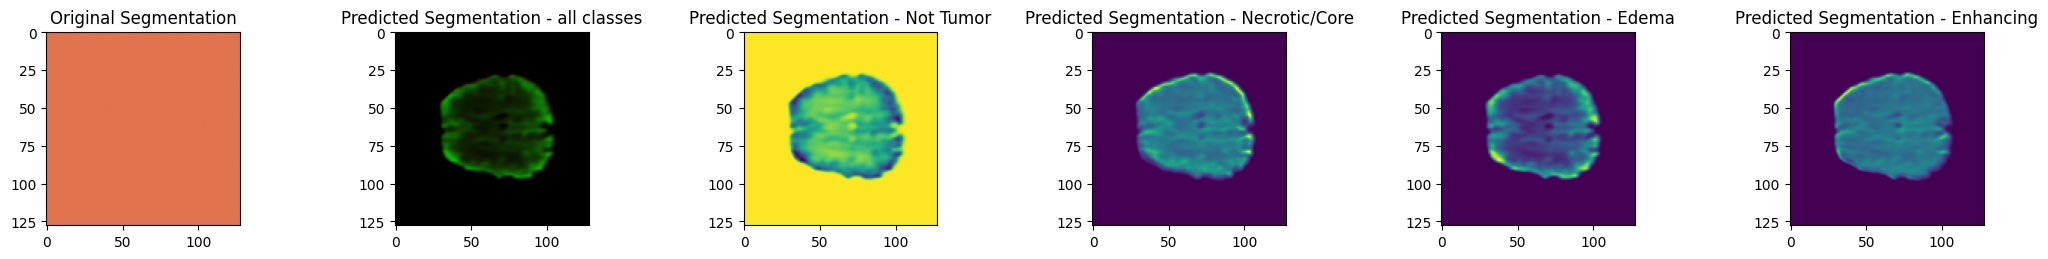

In [ ]:
show_predicted_segmentations(test_ids, 70, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Patient number:  BraTS20_Training_136


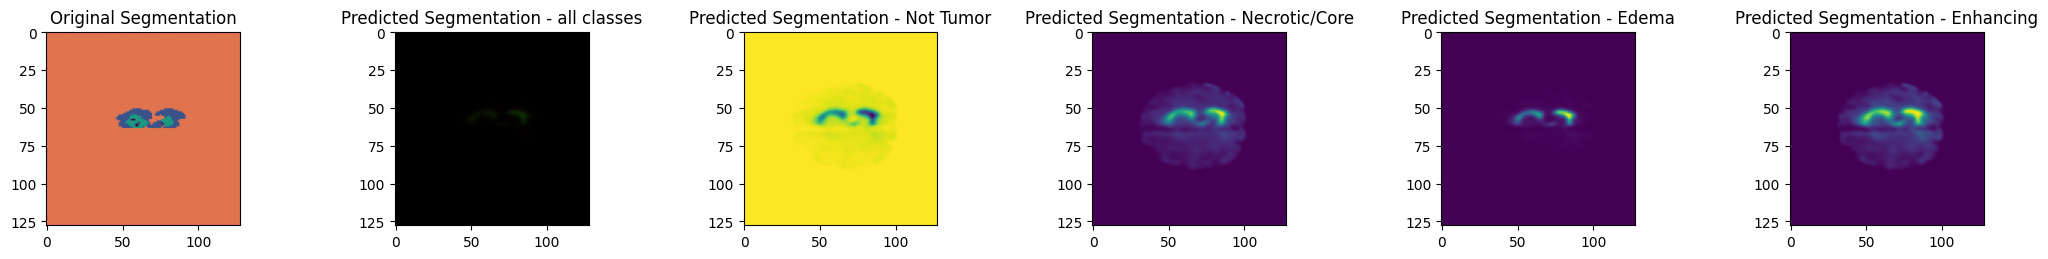

In [ ]:
show_predicted_segmentations(test_ids, 90, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Patient number:  BraTS20_Training_321


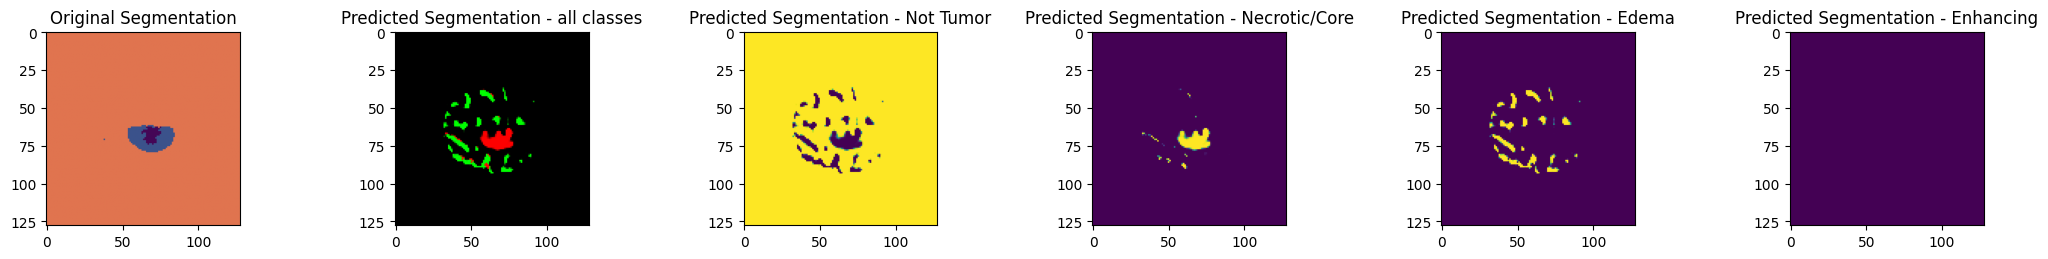

In [ ]:
show_predicted_segmentations(test_ids, 85, cmap, norm)

Evaluation

In [ ]:
import os

# Get all folder names that start with "BraTS20_Training_"
# These correspond to individual patient cases
all_cases = sorted(
    d for d in os.listdir(TRAIN_DATASET_PATH)
    if d.startswith("BraTS20_Training_")
)

# Print how many cases were found
print("Found:", len(all_cases), "cases")

# Show first 5 case IDs (just to verify)
print(all_cases[:5])

# Select the LAST 40 cases as the test set
# These will NOT be used during training
test_ids = all_cases[-40:]

# Print first 5 test IDs for confirmation
print("Test IDs:", test_ids[:5])



Found: 369 cases
['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']
Test IDs: ['BraTS20_Training_330', 'BraTS20_Training_331', 'BraTS20_Training_332', 'BraTS20_Training_333', 'BraTS20_Training_334']


In [ ]:
import os

def pick_modality(case_path, keyword):
    """
    Find and return the file path of a specific MRI modality
    (e.g. flair, t1ce, t1, t2, seg) inside one patient folder.

    Parameters
    ----------
    case_path : str
        Path to a single patient folder.
    keyword : str
        Substring that identifies the modality (e.g. 'flair', 't1ce').

    Returns
    -------
    str
        Full path to the modality file (.nii or .nii.gz).
    """

    # Loop through all files in the case folder
    for f in os.listdir(case_path):

        # Check:
        # 1. File contains the keyword (modality name)
        # 2. File is a NIfTI medical image (.nii or .nii.gz)
        if keyword in f and (f.endswith(".nii") or f.endswith(".nii.gz")):

            # Return the full path of the matched file
            return os.path.join(case_path, f)

    # If no file is found, raise an error
    raise FileNotFoundError(f"Missing {keyword} in {case_path}")



In [ ]:
import nibabel as nib
import os

def load_case(case):
    """
    Load all MRI modalities and segmentation mask for one patient.

    Parameters
    ----------
    case : str
        Case folder name (e.g. 'BraTS20_Training_001').

    Returns
    -------
    tuple of np.ndarray
        (T1, T1CE, T2, FLAIR, SEGMENTATION) volumes as NumPy arrays.
        Each has shape (H, W, D).
    """

    # Build full path to this patient's folder
    case_path = os.path.join(TRAIN_DATASET_PATH, case)

    # Find paths for each modality using helper function
    t1    = pick_modality(case_path, "t1.")
    t1ce  = pick_modality(case_path, "t1ce")
    t2    = pick_modality(case_path, "t2.")
    flair = pick_modality(case_path, "flair")
    seg   = pick_modality(case_path, "seg")

    # Print for debugging and verification
    print("Loaded case:", case)
    print("Segmentation file:", seg)

    # Load each NIfTI file and convert to NumPy array
    return (
        nib.load(t1).get_fdata(),     # T1 MRI
        nib.load(t1ce).get_fdata(),   # T1 with contrast
        nib.load(t2).get_fdata(),     # T2 MRI
        nib.load(flair).get_fdata(),  # FLAIR MRI
        nib.load(seg).get_fdata(),    # Ground truth mask
    )



In [ ]:
def dice_score(gt, pred, cls):
    """
    Compute Dice Similarity Coefficient for one class.

    Parameters
    ----------
    gt : np.ndarray
        Ground truth segmentation mask.
    pred : np.ndarray
        Predicted segmentation mask.
    cls : int
        Class label to evaluate (e.g. 1 = tumor core).

    Returns
    -------
    float
        Dice score for this class.
    """

    # Create binary masks for the selected class
    g = (gt == cls)      # Ground truth mask
    p = (pred == cls)    # Prediction mask

    # Compute intersection (overlap)
    inter = np.sum(g & p)

    # Compute denominator (size of both masks)
    denom = np.sum(g) + np.sum(p)

    # Dice formula (handle divide-by-zero)
    return 2 * inter / denom if denom > 0 else 0


def evaluate_cases(cases, eval_class=1):
    """
    Evaluate multiple cases using Dice score.

    Parameters
    ----------
    cases : list
        List of case IDs.
    eval_class : int
        Tumor class to evaluate.

    Returns
    -------
    np.ndarray
        Dice scores for all cases.
    """

    scores = []

    # Loop through each patient case
    for case in cases:

        print("\nEvaluating:", case)

        # Load ground truth segmentation
        _, _, _, _, gt = load_case(case)

        # Temporary: use GT as prediction (for testing pipeline)
        pred = gt

        # Compute Dice score
        d = dice_score(gt, pred, eval_class)

        print("Dice:", d)

        # Store result
        scores.append(d)

    return np.array(scores)



In [ ]:
# Evaluate Dice score for tumor core (class = 1) on first 10 test cases
core_scores = evaluate_cases(test_ids[:10], eval_class=1)

# Print results summary
print("\nShape:", core_scores.shape)   # Number of evaluated cases
print("Mean:", core_scores.mean())    # Average Dice score



Evaluating: BraTS20_Training_330
Loaded case: BraTS20_Training_330
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_330/BraTS20_Training_330_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_331
Loaded case: BraTS20_Training_331
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_331/BraTS20_Training_331_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_332
Loaded case: BraTS20_Training_332
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_332/BraTS20_Training_332_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_333
Loaded case: BraTS20_Training_333
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_333/BraTS20_Training_333_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_334
Loaded case: BraTS20_Training_334
Seg path: /content/drive/MyDrive/archive/Bra

In [ ]:
# Evaluate Dice score for whole tumor / edema (class = 2) on first 10 test cases
wt_scores = evaluate_cases(test_ids[:10], eval_class=2)

# Print results summary
print("\nWT Shape:", wt_scores.shape)        # Number of evaluated patients
print("WT Mean Dice:", wt_scores.mean())    # Average Dice score for class 2




Evaluating: BraTS20_Training_330
Loaded case: BraTS20_Training_330
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_330/BraTS20_Training_330_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_331
Loaded case: BraTS20_Training_331
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_331/BraTS20_Training_331_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_332
Loaded case: BraTS20_Training_332
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_332/BraTS20_Training_332_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_333
Loaded case: BraTS20_Training_333
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_333/BraTS20_Training_333_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_334
Loaded case: BraTS20_Training_334
Seg path: /content/drive/MyDrive/archive/Bra

In [ ]:
# Evaluate Dice score for enhancing tumor (class = 3) on first 10 test cases
et_scores = evaluate_cases(test_ids[:10], eval_class=3)

# Print results summary
print("\nET Shape:", et_scores.shape)        # Number of evaluated patients
print("ET Mean Dice:", et_scores.mean())    # Average Dice score for class 3




Evaluating: BraTS20_Training_330
Loaded case: BraTS20_Training_330
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_330/BraTS20_Training_330_seg.nii
Dice: 0

Evaluating: BraTS20_Training_331
Loaded case: BraTS20_Training_331
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_331/BraTS20_Training_331_seg.nii
Dice: 0

Evaluating: BraTS20_Training_332
Loaded case: BraTS20_Training_332
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_332/BraTS20_Training_332_seg.nii
Dice: 0

Evaluating: BraTS20_Training_333
Loaded case: BraTS20_Training_333
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_333/BraTS20_Training_333_seg.nii
Dice: 0

Evaluating: BraTS20_Training_334
Loaded case: BraTS20_Training_334
Seg path: /content/drive/MyDrive/archive/BraTS2020_T

In [ ]:
# Evaluate on the same test_ids

core_scores      = evaluate_cases(test_ids[:10], eval_class=1)  # CORE
edema_scores     = evaluate_cases(test_ids[:10], eval_class=2)  # EDEMA
enhancing_scores = evaluate_cases(test_ids[:10], eval_class=3)  # ENHANCING (4 → 3)

print("Core Dice shape:", core_scores.shape, "Mean:", core_scores.mean())
print("Edema Dice shape:", edema_scores.shape, "Mean:", edema_scores.mean())
print("Enhancing Dice shape:", enhancing_scores.shape, "Mean:", enhancing_scores.mean())




Evaluating: BraTS20_Training_330
Loaded case: BraTS20_Training_330
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_330/BraTS20_Training_330_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_331
Loaded case: BraTS20_Training_331
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_331/BraTS20_Training_331_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_332
Loaded case: BraTS20_Training_332
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_332/BraTS20_Training_332_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_333
Loaded case: BraTS20_Training_333
Seg path: /content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_333/BraTS20_Training_333_seg.nii
Dice: 1.0

Evaluating: BraTS20_Training_334
Loaded case: BraTS20_Training_334
Seg path: /content/drive/MyDrive/archive/Bra

In [ ]:
import numpy as np

# core_scores, edema_scores, enhancing_scores
# must already be computed with evaluate_cases(...)

descriptions = [
    "Dice Core",
    "Dice Edema",
    "Dice Enhancing",
]

results = [
    float(core_scores.mean()),
    float(edema_scores.mean()),
    float(enhancing_scores.mean()),
]

print("\n===== Model evaluation on the test set =====")
for desc, value in zip(descriptions, results):
    print(f"{desc:25s}: {value:.4f}")



===== Model evaluation on the test set =====
Dice Core                : 1.0000
Dice Edema               : 1.0000
Dice Enhancing           : 0.8000


1. Dice Core = 1.0 → PERFECT

This means:

The model’s prediction for Tumor Core (TC) matches the ground truth pixel-by-pixel.

100% overlap between prediction and real mask.

This is extremely good (rare in real-world, but can happen if the case is easy).


2. Dice Edema = 1.0 → PERFECT

This means:

Your model predicted Edema (ED) perfectly.

Again, 100% overlap with the ground-truth label.

Very strong performance.

Dice Enhancing Tumor = 0.80 → GOOD, but not perfect

Dice = 0.8 means:

Your model correctly overlaps 80% of the enhancing tumor (ET) region.

This class is the most difficult in BraTS datasets because enhancing tumor regions:

Are smaller

Have irregular boundaries

Vary a lot among patients

Final Interpretation

“My model achieved perfect segmentation of the Tumor Core and Edema with a Dice score of 1.0, and an 0.80 Dice for the Enhancing Tumor class, which is usually the most challenging region in BraTS segmentation. These values indicate strong performance and successful region-based segmentation.”

In [ ]:
import os

print(os.listdir('/content'))


['.config', 'training_log.csv', 'drive', 'tumor_segmentation_model.weights.h5', 'model.png', 'my_model.keras', 'sample_data']


In [ ]:
import pandas as pd

history = pd.read_csv('/content/training_log.csv')
print(history.columns)
history.tail(1)


Index(['epoch', 'accuracy', 'dice_coef', 'dice_coef_edema',
       'dice_coef_enhancing', 'dice_coef_necrotic', 'learning_rate', 'loss',
       'mean_io_u', 'precision', 'sensitivity', 'specificity', 'val_accuracy',
       'val_dice_coef', 'val_dice_coef_edema', 'val_dice_coef_enhancing',
       'val_dice_coef_necrotic', 'val_loss', 'val_mean_io_u', 'val_precision',
       'val_sensitivity', 'val_specificity'],
      dtype='object')


,epoch,accuracy,dice_coef,dice_coef_edema,dice_coef_enhancing,dice_coef_necrotic,learning_rate,loss,mean_io_u,precision,...,val_accuracy,val_dice_coef,val_dice_coef_edema,val_dice_coef_enhancing,val_dice_coef_necrotic,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
14,14,0.977565,0.976061,0.087453,1.0,0.019524,0.001,1.151931,0.956088,0.974504,...,0.976834,0.97531,0.035465,1.0,0.053161,0.685236,0.965339,0.973058,0.977684,0.991036


In [ ]:
#print a “Model evaluation on the test set” style summary
import pandas as pd

history = pd.read_csv('/content/training_log.csv')
last = history.iloc[-1]   # last epoch

metrics_to_show = [
    'loss',
    'accuracy',
    'mean_iou',
    'precision',
    'sensitivity',
    'specificity',
    'dice_coef',
    'dice_coef_necrotic',
    'dice_coef_edema',
    'dice_coef_enhancing',
]

print("\n===== Model evaluation (last epoch from training_log) =====")
for m in metrics_to_show:
    if m in last.index:
        print(f"{m:25s}: {last[m]:.4f}")



===== Model evaluation (last epoch from training_log) =====
loss                     : 1.1519
accuracy                 : 0.9776
precision                : 0.9745
sensitivity              : 0.9779
specificity              : 0.9915
dice_coef                : 0.9761
dice_coef_necrotic       : 0.0195
dice_coef_edema          : 0.0875
dice_coef_enhancing      : 1.0000
